In [18]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [19]:
test_data_size = 30
df1=pd.read_csv("../dataCollection/fromPomber/csvData.csv")
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)
df1.index
print(df1.dtypes)
df1 = df1.diff()
df1.loc['2020-01-22', 'confirmed'] = 0.0
df1['confirmed'] = df1['confirmed'].astype(np.int64)
print(df1.head(15))
df1.dtypes

train1 = df1[:-test_data_size]
test1 = df1[-test_data_size:]
train1.shape

confirmed    int64
deaths       int64
recovered    int64
dtype: object
            confirmed  deaths  recovered
date                                    
2020-01-22          0     NaN        NaN
2020-01-23          0     0.0        0.0
2020-01-24          0     0.0        0.0
2020-01-25          0     0.0        0.0
2020-01-26          0     0.0        0.0
2020-01-27          0     0.0        0.0
2020-01-28          0     0.0        0.0
2020-01-29          0     0.0        0.0
2020-01-30          1     0.0        0.0
2020-01-31          0     0.0        0.0
2020-02-01          0     0.0        0.0
2020-02-02          1     0.0        0.0
2020-02-03          1     0.0        0.0
2020-02-04          0     0.0        0.0
2020-02-05          0     0.0        0.0


(192, 3)

In [20]:
#print(train1)

In [21]:
#print(test1)

In [24]:
fig1 = px.bar(df1, color="confirmed", color_continuous_scale=px.colors.sequential.BuGn)
fig1.update_layout(title_text='Confirmed COVID-19 cases per day in India')
fig1.show()

In [35]:
df1 = df1.reset_index()
train1 = train1.reset_index()
test1 = test1.reset_index()

In [36]:
sns.set(palette = 'Set1',style='darkgrid')
  
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll1(case='confirmed'):
    ts1=df1
    ts1=ts1[['date',case]]
    ts1=ts1.set_index('date')
    ts1.astype('int64')
    a=len(ts1.loc[(ts1['confirmed']>=10)])
    ts1=ts1[-a:]
    return (ts1.rolling(window=4,center=False).mean().dropna())
def rollPlot1(case='confirmed'):
    ts=df1
    ts=ts[['date',case]]
    ts=ts.set_index('date')
    ts.astype('int64')
    a=len(ts.loc[(ts['confirmed']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard')
    plt.xticks([])

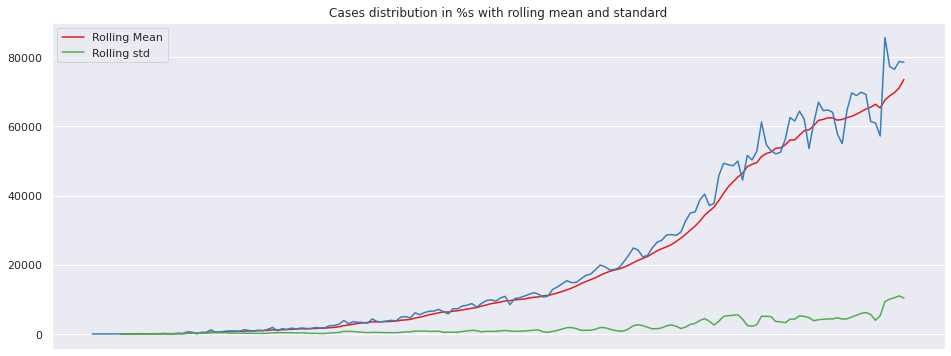

In [37]:
tsC2=roll1()
rollPlot1()

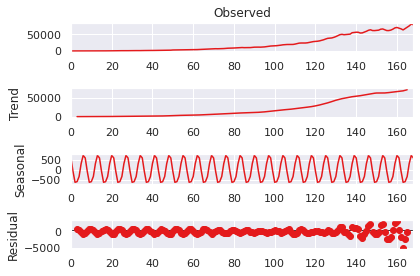

In [38]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC2.values,freq=7).plot()

In [39]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity1(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For India
tsC3=tsC2['confirmed'].values
stationarity1(tsC3)

Results of Dickey-Fuller Test:
Test Statistic                   2.219669
p-value                          0.998898
#Lags Used                      14.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


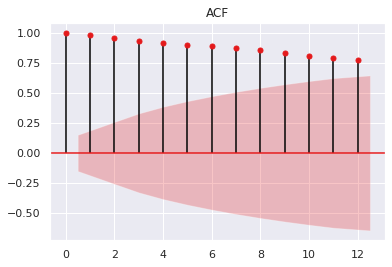

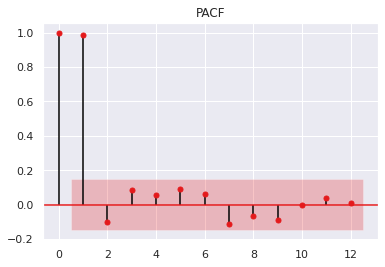

In [40]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    
#For India
corr(tsC2)

In [41]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train1 = train1.set_index(['date'])
test1 = test1.set_index(['date'])

In [42]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

train_features1=pd.DataFrame(create_features(train1))
test_features1=pd.DataFrame(create_features(test1))
features_and_target_train1 = pd.concat([train1,train_features1], axis=1)
features_and_target_test1 = pd.concat([test1,test_features1], axis=1)

features_and_target_train1= FunLabelEncoder(features_and_target_train1)

In [44]:
x_train1= features_and_target_train1[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
y11 = features_and_target_train1[['confirmed']]
x_test1 = features_and_target_test1[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]

In [45]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)
#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  141
Model:                 ARIMA(4, 2, 1)   Log Likelihood               -1036.457
Method:                       css-mle   S.D. of innovations            368.117
Date:                Thu, 29 Oct 2020   AIC                           2086.915
Time:                        01:38:15   BIC                           2107.556
Sample:                             2   HQIC                          2095.302
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4642      7.320      0.746      0.455      -8.883      19.812
ar.L1.D2.y    -0.0953      0.062     -1.542      0.123      -0.216       0.026
ar.L2.D2.y    -0.2887      0.057     -5.054      0.0

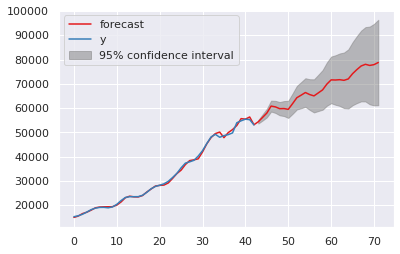

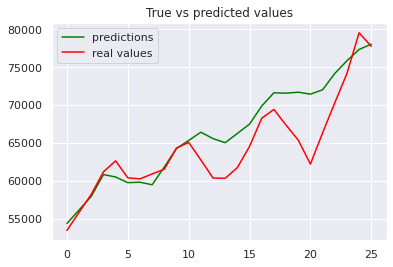

In [46]:
train1,test1=split(tsC3)
pred1=arima(train1,test1)